In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [3]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
features = 'orbsummaryfeaturesxgbNorbits10000.0Nout1000window10/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['t_final_short' 'avg_beta12' 'std_beta12' 'min_beta12' 'max_beta12'
 'avg_beta23' 'std_beta23' 'min_beta23' 'max_beta23' 'avg_a1' 'std_a1'
 'max_a1' 'min_a1' 'norm_std_a1' 'norm_max_a1' 'norm_std_window10_a1'
 'norm_max_window10_a1' 'avg_e1' 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1'
 'norm_max_e1' 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1'
 'std_inc1' 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window10_inc2' 'avg_eH2' 'std_eH2' '

In [4]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
9994,0009995.bin,9.990000e+08,9.990000e+08,True
9995,0009996.bin,3.814426e+06,6.124299e+06,False
9996,0009997.bin,1.498363e+04,3.320307e+03,False
9997,0009998.bin,9.419807e+05,8.353625e+05,False
9998,0009999.bin,1.895071e+07,2.047024e+07,False


In [5]:
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features += ['avg_beta12','std_beta12','min_beta12','max_beta12','avg_beta23','std_beta23','min_beta23','max_beta23'] 
y = labels['Stable']
X = dataset[features]
X.head()

,avg_iH1,avg_iH2,norm_std_a1,norm_max_a1,norm_std_window10_a1,norm_max_window10_a1,norm_std_a2,norm_max_a2,norm_std_window10_a2,norm_max_window10_a2,...,norm_a2_slope,norm_a3_slope,avg_beta12,std_beta12,min_beta12,max_beta12,avg_beta23,std_beta23,min_beta23,max_beta23
0,0.469412,0.305877,0.000015,0.000054,0.000017,0.000031,0.000011,0.000060,0.000010,0.000017,...,1.579422e-14,-1.328609e-12,28.595534,0.001890,28.589437,28.602055,3.701169,0.033944,3.521541,3.745299
1,3.306766,1.733165,0.000078,0.000341,0.000105,0.000296,0.000032,0.000084,0.000033,0.000060,...,-7.967625e-14,1.914185e-12,13.483037,0.005900,13.456567,13.493507,4.539888,0.052812,4.409433,4.621959
2,0.544402,0.283334,0.000343,0.001693,0.000154,0.000294,0.000027,0.000080,0.000032,0.000062,...,-1.998956e-14,1.732883e-16,5.870287,0.017665,5.783332,5.892522,28.628449,0.001945,28.622706,28.631477
3,1.548626,1.987273,0.000050,0.000106,0.000018,0.000026,0.000462,0.000908,0.000216,0.000297,...,6.785336e-12,6.262206e-14,15.489569,0.027443,15.440107,15.543339,21.682048,0.033527,21.613107,21.742780
4,3.655932,1.392835,0.000182,0.000720,0.000059,0.000089,0.000319,0.001340,0.000192,0.000342,...,-3.021927e-12,-5.494854e-13,5.324380,0.034673,5.200037,5.475681,10.280581,0.016301,10.213489,10.338279


In [6]:
X.shape

(9999, 37)

In [7]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [8]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [10]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.88878378                                          
ERROR                                               
0.006081731180972999                                
HOLDOUT SCORE                                       
0.9060835986464282                                  
SCORE:                                                                        
0.89155618                                                                    
ERROR                                                                         
0.006197047101518634                                                          
HOLDOUT SCORE                                                                 
0.9097899581791392                                                            
SCORE:                                                                        
0.88309292                                                                    
ERROR                                             

0.004809254403240941                                                           
HOLDOUT SCORE                                                                  
0.9091546003580302                                                             
SCORE:                                                                         
0.88197096                                                                     
ERROR                                                                          
0.007254947978553266                                                           
HOLDOUT SCORE                                                                  
0.8943722373337016                                                             
SCORE:                                                                         
0.89175808                                                                     
ERROR                                                                          
0.006112991461459853                    

0.006820907299772439                                                           
HOLDOUT SCORE                                                                  
0.9111145177045022                                                             
SCORE:                                                                         
0.84594418                                                                     
ERROR                                                                          
0.009810835981246574                                                           
HOLDOUT SCORE                                                                  
0.8672919313990921                                                             
SCORE:                                                                         
0.8932903000000001                                                             
ERROR                                                                          
0.00647882832208666                     

In [12]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.19990923427565954,
 'x_max_depth': 13,
 'x_min_child': 5.0,
 'x_pos_weight': 14.92913564221831,
 'x_subsample': 0.8511014834836558,
 'x_tree_colsample': 0.559027529613611}

In [13]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.918078+0.0038567	test-auc:0.846225+0.00916398
[1]	train-auc:0.950795+0.00483896	test-auc:0.872569+0.00705589
[2]	train-auc:0.962765+0.00272115	test-auc:0.885958+0.00657697
[3]	train-auc:0.969637+0.00240435	test-auc:0.89383+0.00412555
[4]	train-auc:0.975721+0.00186887	test-auc:0.89955+0.00427101
[5]	train-auc:0.979671+0.00104187	test-auc:0.902942+0.00351156
[6]	train-auc:0.983347+0.000815929	test-auc:0.905592+0.00370772
[7]	train-auc:0.985657+0.000636994	test-auc:0.90721+0.00408384
[8]	train-auc:0.988134+0.000972344	test-auc:0.90857+0.0032696
[9]	train-auc:0.989989+0.00117491	test-auc:0.910409+0.00304934
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.918078       0.003857       0.846225      0.009164
1        0.950795       0.004839       0.872569      0.007056
2        0.962765       0.002721       0.885958      0.006577
3        0.969637       0.002404       0.893830      0.004126
4        0.975721       0.001869       0.899550      0.004271
5

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.7939849819315827


In [14]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9253191675355591
0.8297131564454646


In [15]:
print(best)

{'x_learning_rate': 0.19990923427565954, 'x_max_depth': 13, 'x_min_child': 5.0, 'x_pos_weight': 14.92913564221831, 'x_subsample': 0.8511014834836558, 'x_tree_colsample': 0.559027529613611}


Text(0.5, 1.0, 'ROC curve (AUC = 0.925)')

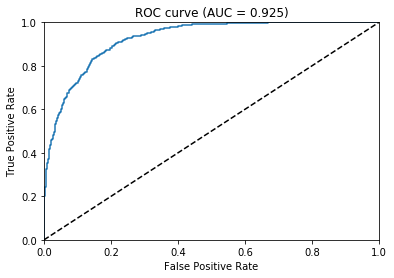

In [16]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [17]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.0008699611062183976, recall = 1.0, precision = 0.3570957095709571
Threshold 0.0009361044503748417, recall = 0.9981515711645101, precision = 0.36
Threshold 0.0010058321058750153, recall = 0.9981515711645101, precision = 0.36363636363636365
Threshold 0.001118999207392335, recall = 0.9981515711645101, precision = 0.3673469387755102
Threshold 0.001211795723065734, recall = 0.9981515711645101, precision = 0.3711340206185567
Threshold 0.0013260645791888237, recall = 0.9981515711645101, precision = 0.375
Threshold 0.0014412089949473739, recall = 0.9981515711645101, precision = 0.37894736842105264
Threshold 0.0015284591354429722, recall = 0.9981515711645101, precision = 0.3829787234042553
Threshold 0.001819562166929245, recall = 0.9981515711645101, precision = 0.3870967741935484
Threshold 0.002004799200221896, recall = 0.9981515711645101, precision = 0.391304347826087
Threshold 0.0021726100239902735, recall = 0.9981515711645101, precision = 0.3956043956043956
Threshold 0.0024831814

AUC Score (Test): 0.829713


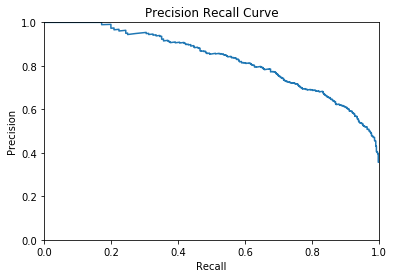

In [18]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.9985948  0.9979538  0.99273586 0.37573275 0.076075  ]
541 1459
[930.  65.  48.  45.  29.  13.  10.  13.   9.   9.  11.  10.  13.   8.
   8.   6.  10.   3.  10.   3.   7.   1.   4.   2.   3.   4.   2.   5.
   6.   9.   6.   3.   5.   3.   7.   6.   6.   5.   9.   6.   8.   7.
   4.  11.   7.  10.  10.   9.  18.  23.]
[ 15  10   8   6   6   3   4   4   5   4   5   2   5   2   4   2   4   1
   4   3   6   4   3   3   5   4   1   2   3   3   5   7   4   3   4   2
   4   3   3   9   6   8  12   8  14  12  17  28  37 131]


(0, 350)

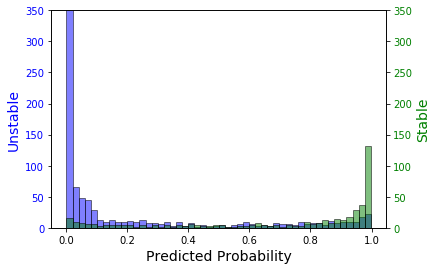

In [19]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

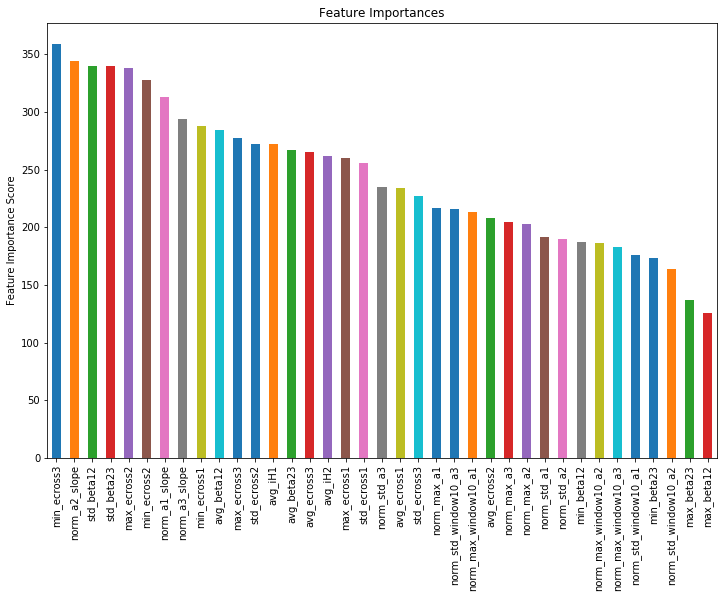

In [20]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [19]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/neworbsummaryfeaturesxgb_resonant.pkl", "wb"))